***Toxic Comment Classification***

***Authors:***

***Guneykan Ozkaya***

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import zipfile
from PIL import Image
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import plotly.offline as pltly
import plotly.graph_objs as go
from sklearn.metrics import classification_report
pltly.init_notebook_mode(connected=True)

In [5]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

100%|██████████████████████████████████████| 52.6M/52.6M [00:04<00:00, 11.1MB/s]
100%|██████████████████████████████████████| 52.6M/52.6M [00:04<00:00, 12.9MB/s]


In [8]:
with zipfile.ZipFile("jigsaw-toxic-comment-classification-challenge.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [9]:
with zipfile.ZipFile("train.csv.zip", 'r') as zip_ref:
    zip_ref.extractall()


In [46]:
with zipfile.ZipFile("test.csv.zip", 'r') as zip_ref:
    zip_ref.extractall()

# EDA

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_trials = df_train.drop(["id"], axis=1)

In [3]:
# Sneak Peak
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# No missing values
df_trials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


In [5]:
df_trials["len"] = np.zeros(len(df_trials))
for a in range(len(df_trials)):
    df_trials.iloc[a, -1] = len(df_trials.loc[a, "comment_text"].split())

***most of the comment lenght are around 0-600 lenght, this more-less will determine embed. dimension***

Text(0.5, 1.0, 'Comment Lenghts')

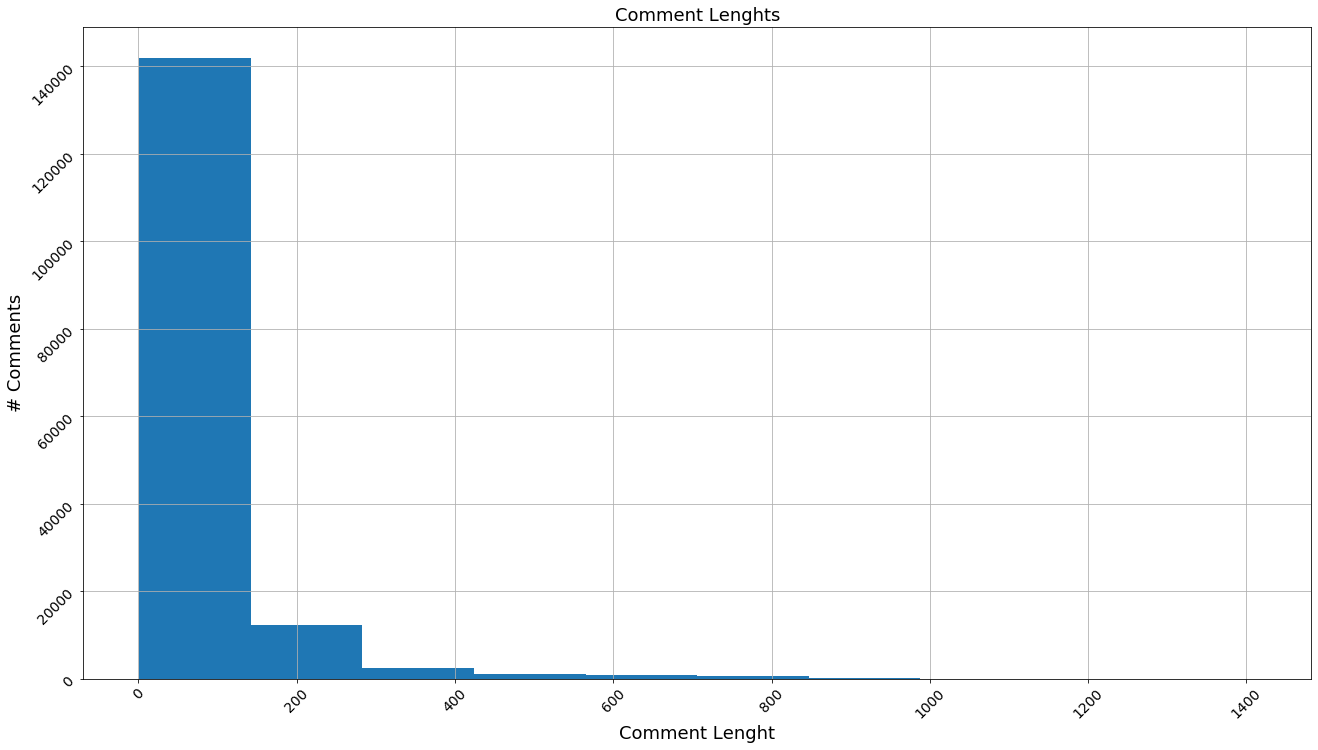

In [14]:
plt.figure(figsize=(22,12))
df_trials.len.hist()
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14, rotation=45)
plt.xlabel("Comment Lenght", fontsize=18)
plt.ylabel("# Comments", fontsize=18)
plt.title("Comment Lenghts", fontsize=18)

***Subsetting labels to check class imbalance***

In [15]:
toxic = df_trials.toxic == 1
severe_toxic = df_trials.severe_toxic == 1
obscene = df_trials.obscene == 1
threat = df_trials.threat == 1
insult = df_trials.insult == 1
iden_hate = df_trials.identity_hate == 1
natural = (df_trials.toxic != 1) & (df_trials.obscene != 1) & (
    df_trials.threat != 1) & (df_trials.insult != 1) & (df_trials.identity_hate != 1) & (df_trials.severe_toxic != 1)

***Storing unlabelled comments as clean comment***

In [16]:
df_trials["clean"] = np.zeros(len(df_trials))
df_trials["clean"][natural] = 1

/Users/guneykan/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
df_trials["class_str"] = np.zeros(len(df_trials))
classes = [natural, toxic, obscene, threat, insult, iden_hate, severe_toxic]
labels = ["Clean", "Toxic", "Obscene", "Threat", "Insult", "Iden_hate", "Severe_toxic"]
for a in range(len(classes)):
    df_trials["class_str"][classes[a]] = labels[a] # subsetting labels

/Users/guneykan/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



***Severe class imbalance most of the comments are unlabelled, just regular comments. especially threat will create problems to predict. Probably any model will fail to classify threat if we do not oversample. 
Problem: How to oversample with text data?***

***Some good approaches can be found in this post:***

https://medium.com/@kothiya.yogesh/how-i-handled-imbalanced-text-data-ba9b757ab1d8

Text(0.5, 1.0, 'Class Imbalance')

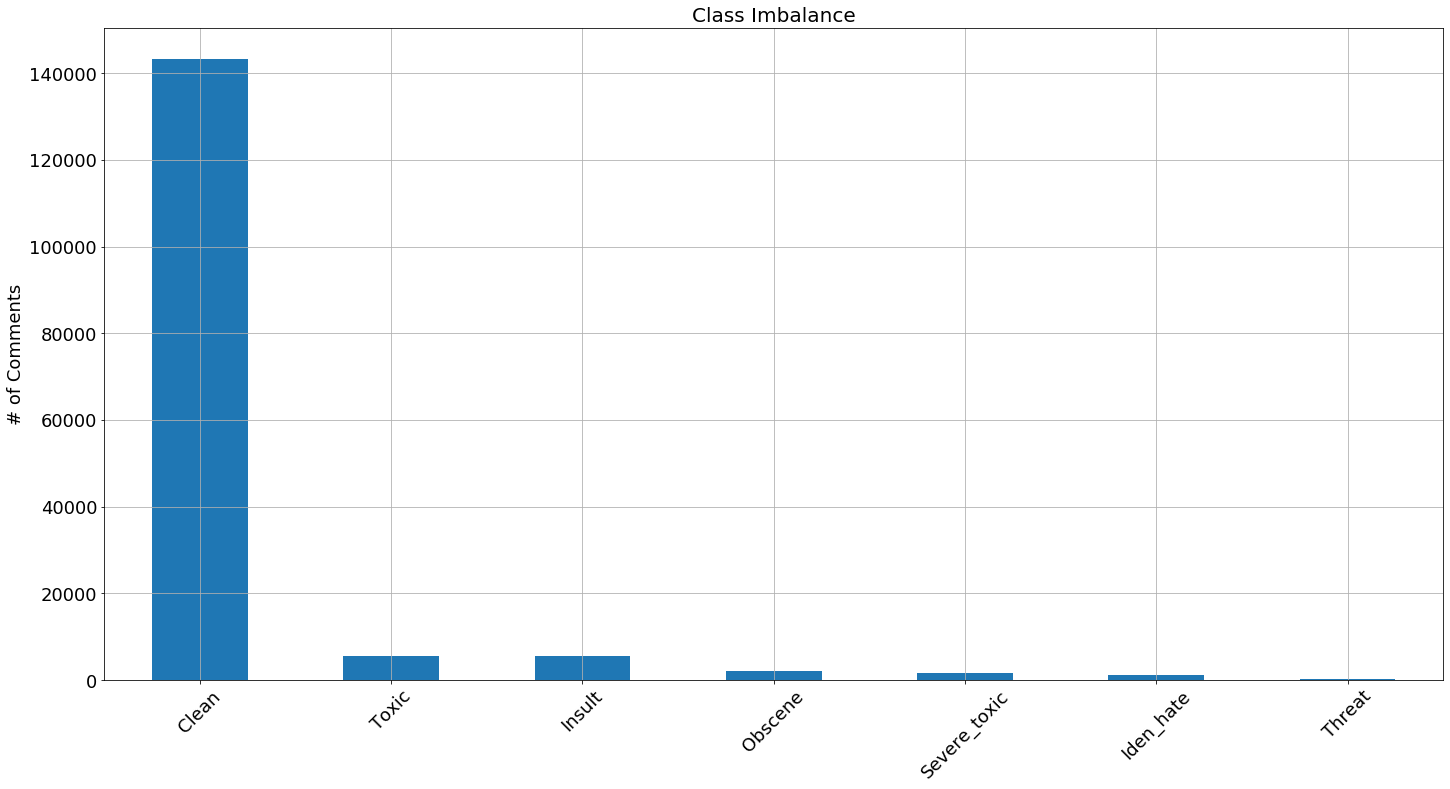

In [28]:
# Severe Class imbalance
plt.figure(figsize=(24,12))
df_trials["class_str"].value_counts().plot(kind="bar", grid=True, fontsize=18, rot=45)
plt.ylabel("# of Comments", fontsize=18)
plt.title("Class Imbalance", fontsize=20)

***Only have 148 threat labels probably model will not be able to classify any threat comments***

In [12]:
df_trials["class_str"].value_counts()

Clean           143346
Toxic             5666
Insult            5649
Obscene           2075
Severe_toxic      1595
Iden_hate         1092
Threat             148
Name: class_str, dtype: int64

***Visualizing the most common words for each specific label***

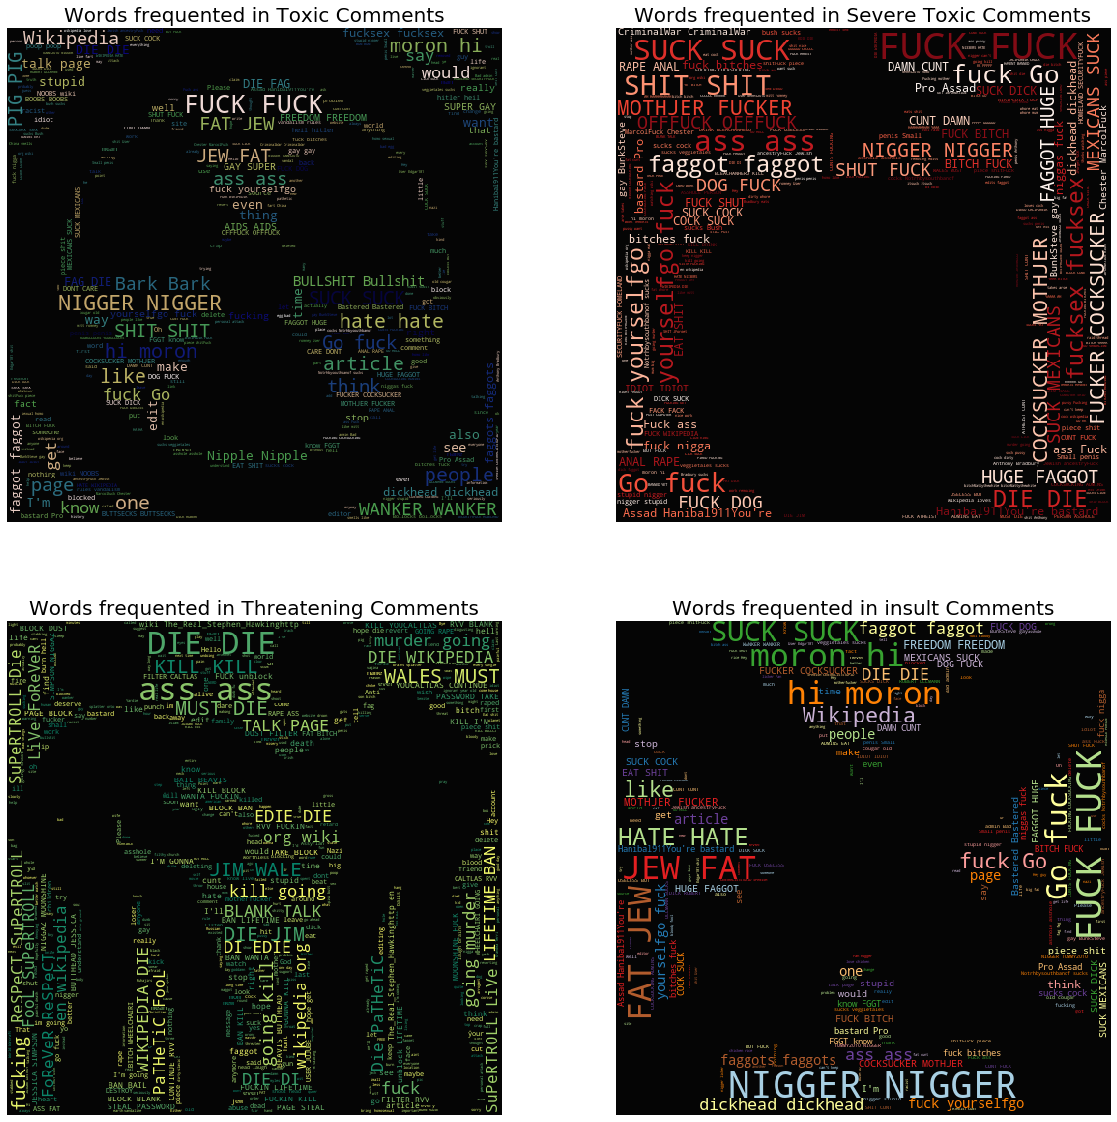

In [31]:
stopword = stopwords.words("english")
toxic_mask=np.array(Image.open("toxic-sign.png"))
toxic_mask=toxic_mask[:,:,1]
#wordcloud for Toxic comments
subset=df_trials[df_trials.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,mask=toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
severe_toxic_mask=np.array(Image.open("bomb.png"))
severe_toxic_mask=severe_toxic_mask[:,:,1]
subset=df_trials[df_trials.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
threat_mask=np.array(Image.open("anger.png"))
threat_mask=threat_mask[:,:,1]
subset=df_trials[df_trials.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
insult_mask=np.array(Image.open("swords.png"))
insult_mask=insult_mask[:,:,1]
subset=df_trials[df_trials.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()


## Pre-Process

 - Stop Word-Digit Removal
 - Train-Test Split
 - Tokenize-Padding

### Stop Word-Digit Removal

In [32]:
def process(doc, stopwords):
    text = []
    for a in doc:
        sentence = a.lower() # Lower case all words
        for word in stopwords:
            token = " " + word + " " 
            sentence = sentence.replace(token, " ") # replace the stopword
            sentence = re.sub(r"\d+", "", sentence) # replace the digits
            sentence = sentence.replace("  ", " ") # replace double spaces
            sentence = sentence.replace("   ", " ") # replace triple spaces, in case there are any
            sentence = sentence.replace("fck", "fuck") # adding a bit more toxic content
        text.append(sentence)
    return text

### Train-Test Split

In [33]:
df_model = df_trials.drop(["len", "class_str", "clean"], axis = 1)
y = df_model.drop(["comment_text"], axis=1).values # Target
text = df_model["comment_text"].values
X = process(text, stopword) # Process all text, stopword defined in the cell of wordclouds

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) # Train-Test Split

print(" Target Train Shape: ", np.array(y_train).shape, "\n", 
     "Features Train Shape: ", np.array(X_train).shape, "\n", 
     "Features Test Shape:", np.array(X_test).shape, "\n", 
     "Target Test Shape:", np.array(y_test).shape, "\n")

print("Sneak Peak to some comments:", "\n", "\n",  
     X_train[0], "\n", "\n", 
     X_train[1])

 Target Train Shape:  (127656, 6) 
 Features Train Shape:  (127656,) 
 Features Test Shape: (31915,) 
 Target Test Shape: (31915, 6) 

Sneak Peak to some comments: 
 
 samantha harrison 

hi. i've reverted edits article samantha harrison again, simply can't find references them.

you're new here, i'll explain simply: every article, especially articles living people, need provide source stated fact. put another way - samantha harrison came along wikipedia article found something true her, could get lot trouble (see libel). referenced fact another reliable source (say, newspaper article website), blame untrue information verified another source (even source untrue fact).

samantha member southern districts hockey club fact, even though referenced you, quick google search took new zealand herald article stating so, added article reference fact. however, facts added return anything useful reference, can't state - can't find anything going cambridge, parents' divorce (which latter also irre

### Tokenize and padding

***Tokenizing and creating corpus***

In [35]:
vocab_size = 10000 # how many unique words, it will keep most frequent 10k words 
embedding_dim = 50 # Word vector dimension
oov_tok = "<OOV>" # token for unknown words

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) # define tokenizer
tokenizer.fit_on_texts(X_train) # Fit only on training data
word_index = tokenizer.word_index # corpus
sequences_train = tokenizer.texts_to_sequences(X_train) # create sequences with tokens
sequences_test = tokenizer.texts_to_sequences(X_test) # using tokens from training sample



***To determine padding size, 300 seems decent.***

Text(0.5, 1.0, 'Comment Lenghts')

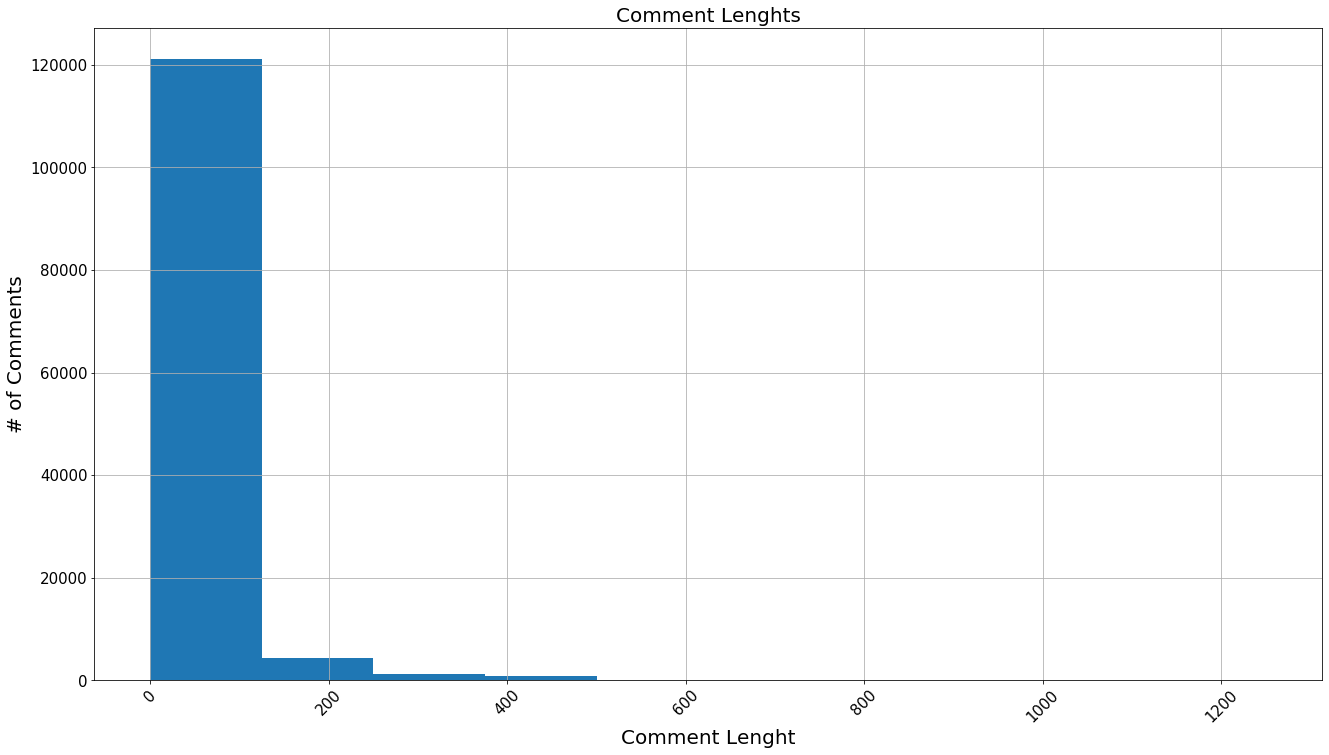

In [40]:
lens = [len(a) for a in sequences_train]
plt.figure(figsize=(22,12))
plt.hist(lens)
plt.grid()
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)
plt.ylabel("# of Comments", fontsize=20)
plt.xlabel("Comment Lenght", fontsize=20)
plt.title("Comment Lenghts", fontsize=20)

***Padding***

In [42]:
max_len = 300  #  Max_length of each comment
trunc_type = "post"  # It will cut the comments from end if it is longer than 300 tokens
pad_type = "post"  # It will pad at the end of sentence if comment is shorter than 300 tokens

padded_train = pad_sequences(
    sequences_train, maxlen=max_len, truncating=trunc_type, padding=pad_type)
padded_test = pad_sequences(
    sequences_test, maxlen=max_len, truncating=trunc_type, padding=pad_type)

***Token Decoder and Reverse word index for T-sne plot later***

In [43]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) # Reversing corpus so we can decode it back to sentences

def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text]) # It will return ? if the key does not exist

print(decode(padded_train[1]))
print(X_train[1])

i fully support this details clutter also <OOV> issues go ahead it ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
i fully support this. details clutter also recentism issues. go ahead it.


# First Model - FFNN

## Model Summary

In [112]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len), # embedding layer
    tf.keras.layers.GlobalMaxPooling1D(), # Training is so slow with flatten layer
    tf.keras.layers.Dense(50, activation="selu", kernel_initializer="lecun_normal"), # Fully Connected
    tf.keras.layers.AlphaDropout(0.2), # Dropout for regularization, easily overfits
    tf.keras.layers.Dense(20, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(0.2), 
    tf.keras.layers.Dense(6, activation="sigmoid") # Output layer with sigmoid activation, there are common labels cannot use softmax
])
call_back = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True) # early-stopping, stops training if loss do not decrease after 3 epochs
model.compile(loss='binary_crossentropy',optimizer='Nadam',metrics=['accuracy'])
model.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 300, 50)           500000    
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                2550      
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 50)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 20)                1020      
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 20)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 6)               

## Model Architecture

![Model Arch.](model_ffnn.png)

## Fit the Model

In [113]:
num_epochs = 40
model.fit(padded_train, y_train, epochs=num_epochs, validation_split=0.2, callbacks = [call_back])

Train on 102124 samples, validate on 25532 samples
Epoch 1/40
102124/102124 [==============================] - 14s 134us/sample - loss: 0.1381 - accuracy: 0.9576 - val_loss: 0.1575 - val_accuracy: 0.9635
Epoch 2/40
102124/102124 [==============================] - 12s 122us/sample - loss: 0.0801 - accuracy: 0.9744 - val_loss: 0.0666 - val_accuracy: 0.9791
Epoch 3/40
102124/102124 [==============================] - 13s 124us/sample - loss: 0.0568 - accuracy: 0.9799 - val_loss: 0.0675 - val_accuracy: 0.9799
Epoch 4/40
102124/102124 [==============================] - 13s 127us/sample - loss: 0.0523 - accuracy: 0.9809 - val_loss: 0.0628 - val_accuracy: 0.9804
Epoch 5/40
102124/102124 [==============================] - 13s 130us/sample - loss: 0.0492 - accuracy: 0.9816 - val_loss: 0.0657 - val_accuracy: 0.9806
Epoch 6/40
102124/102124 [==============================] - 14s 134us/sample - loss: 0.0474 - accuracy: 0.9821 - val_loss: 0.0647 - val_accuracy: 0.9802
Epoch 7/40
102124/102124 [=====

## FFNN Results 

***Converting Probs to Classes***

In [114]:
probs_ff = model.predict(padded_test)
classes_ff = []
for a in probs_ff:
    z = []
    for b in a:
        if b>0.5:
            z.append(1)
        else:
            z.append(0)
    classes_ff.append(z)
    

### Classification Report

In [115]:
print(classification_report(y_test, classes_ff, target_names=["toxic", "severe_tox", "obscene", "threat", "insult", "iden_hate"]))

              precision    recall  f1-score   support

       toxic       0.86      0.65      0.74      3043
  severe_tox       0.59      0.09      0.16       307
     obscene       0.86      0.70      0.77      1638
      threat       0.00      0.00      0.00       109
      insult       0.74      0.55      0.63      1543
   iden_hate       0.00      0.00      0.00       274

   micro avg       0.83      0.58      0.68      6914
   macro avg       0.51      0.33      0.38      6914
weighted avg       0.77      0.58      0.66      6914
 samples avg       0.06      0.05      0.05      6914



/Users/guneykan/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/guneykan/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

/Users/guneykan/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.



### FFNN - Remarks

 - Model achieves to classify toxic-obscene-insult comments fairly good
 - Its appearant that it learns specific features to severe-toxic class but recall is too low, it is wrongly classifying a lot of severe-toxic points.
 - When it comes to threat, identity hate, class imbalance is too severe model cannot learn anything specific to those classes

# Second Model - Vanilla RNN

## Model Summary

In [116]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=300),
    # Adding dropout to reccurent units too, LSTM easily overfits
    tf.keras.layers.SimpleRNN(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='sigmoid')
])
call_back = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model_rnn.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 300, 50)           500000    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 300, 50)           5050      
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 50)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 20)                1020      
_________________________________________________________________
dropout_22 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 6)                 126       
Total params: 506,196
Trainable params: 506,196
Non-trainable params: 0
_______________________________________________

## Model. Arch.

![Model Arch.](model_rnn.png)

## Fit the Model

In [117]:
num_epochs = 40
model_rnn.fit(padded_train, y_train, epochs=num_epochs, validation_split=0.2, callbacks = [call_back])

Train on 102124 samples, validate on 25532 samples
Epoch 1/40
102124/102124 [==============================] - 390s 4ms/sample - loss: 0.1199 - accuracy: 0.9672 - val_loss: 0.0600 - val_accuracy: 0.9783
Epoch 2/40
102124/102124 [==============================] - 384s 4ms/sample - loss: 0.0558 - accuracy: 0.9804 - val_loss: 0.0538 - val_accuracy: 0.9806
Epoch 3/40
102124/102124 [==============================] - 403s 4ms/sample - loss: 0.0499 - accuracy: 0.9821 - val_loss: 0.0538 - val_accuracy: 0.9811
Epoch 4/40
102124/102124 [==============================] - 401s 4ms/sample - loss: 0.0458 - accuracy: 0.9828 - val_loss: 0.0528 - val_accuracy: 0.9812
Epoch 5/40
102124/102124 [==============================] - 385s 4ms/sample - loss: 0.0420 - accuracy: 0.9842 - val_loss: 0.0533 - val_accuracy: 0.9810
Epoch 6/40
102124/102124 [==============================] - 366s 4ms/sample - loss: 0.0393 - accuracy: 0.9850 - val_loss: 0.0562 - val_accuracy: 0.9812
Epoch 7/40
102124/102124 [===========

## Vanilla RNN Results 

In [118]:
probs_rnn = model_rnn.predict(padded_test)
classes_rnn = []
for a in probs_rnn:
    z = []
    for b in a:
        if b>0.5:
            z.append(1)
        else:
            z.append(0)
    classes_rnn.append(z)

### Classification Report

In [119]:
print(classification_report(y_test, classes_rnn, target_names=["toxic", "severe_tox", "obscene", "threat", "insult", "iden_hate"]))

              precision    recall  f1-score   support

       toxic       0.83      0.70      0.76      3043
  severe_tox       0.67      0.25      0.37       307
     obscene       0.84      0.77      0.81      1638
      threat       0.00      0.00      0.00       109
      insult       0.76      0.57      0.65      1543
   iden_hate       0.00      0.00      0.00       274

   micro avg       0.82      0.63      0.71      6914
   macro avg       0.52      0.38      0.43      6914
weighted avg       0.76      0.63      0.69      6914
 samples avg       0.06      0.06      0.06      6914



### Vanilla RNN Remarks

 - As in the case of FFNN, model cannot classify threat and identity hate comment because of the class imbalance
 - It performs slightly better than FNN
 - RNN can classify severe toxic comments relativly well and gives slight improvement in all different classes

# Third Model Unidirectional LSTM

## Model Summary

In [124]:
model_lstm_0 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=300),
    # Adding dropout to reccurent units too, LSTM easily overfits
    tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.1), # Increase dropout compared to vanilla RNN, LSTM overfits data faster compared to RNN
    tf.keras.layers.Dense(6, activation='sigmoid')
])
call_back = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model_lstm_0.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model_lstm_0.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 300, 50)           500000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 50)           20200     
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 50)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 20)                1020      
_________________________________________________________________
dropout_24 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 6)                 126       
Total params: 521,346
Trainable params: 521,346
Non-trainable params: 0
_______________________________________________

## Model Arch.

![Model Arch.](model_unilstm.png)

## Fit the Model

In [125]:
num_epochs = 10
model_lstm_0.fit(padded_train, y_train, epochs=num_epochs, validation_split=0.2, callbacks = [call_back])

Train on 102124 samples, validate on 25532 samples
Epoch 1/10
102124/102124 [==============================] - 653s 6ms/sample - loss: 0.0776 - accuracy: 0.9754 - val_loss: 0.0520 - val_accuracy: 0.9811
Epoch 2/10
102124/102124 [==============================] - 577s 6ms/sample - loss: 0.0495 - accuracy: 0.9821 - val_loss: 0.0514 - val_accuracy: 0.9815
Epoch 3/10
102124/102124 [==============================] - 621s 6ms/sample - loss: 0.0454 - accuracy: 0.9829 - val_loss: 0.0511 - val_accuracy: 0.9814
Epoch 4/10
102124/102124 [==============================] - 612s 6ms/sample - loss: 0.0418 - accuracy: 0.9839 - val_loss: 0.0535 - val_accuracy: 0.9816
Epoch 5/10
102124/102124 [==============================] - 661s 6ms/sample - loss: 0.0386 - accuracy: 0.9848 - val_loss: 0.0541 - val_accuracy: 0.9812
Epoch 6/10
102124/102124 [==============================] - 572s 6ms/sample - loss: 0.0358 - accuracy: 0.9857 - val_loss: 0.0557 - val_accuracy: 0.9810


## Unidirectional LSTM Results

In [126]:
probs_lstm_0 = model_lstm_0.predict(padded_test)
classes_lstm_0 = []
for a in probs_lstm_0:
    z = []
    for b in a:
        if b>0.5:
            z.append(1)
        else:
            z.append(0)
    classes_lstm_0.append(z)

### Classification Report

In [127]:
print(classification_report(y_test, classes_lstm_0, target_names=["toxic", "severe_tox", "obscene", "threat", "insult", "iden_hate"]))

              precision    recall  f1-score   support

       toxic       0.86      0.69      0.77      3043
  severe_tox       0.30      0.01      0.02       307
     obscene       0.83      0.77      0.80      1638
      threat       0.00      0.00      0.00       109
      insult       0.77      0.60      0.67      1543
   iden_hate       0.00      0.00      0.00       274

   micro avg       0.83      0.62      0.71      6914
   macro avg       0.46      0.35      0.38      6914
weighted avg       0.76      0.62      0.68      6914
 samples avg       0.06      0.06      0.06      6914



### Unidirectional LSTM Remarks

 - In case of severe toxic it performs worse compared to vanilla RNN
 - Achieves slightly better results on other classes
 - Overall suffers from class imbalance as previous models

# Fourth Model - Bidirectional LSTM

## Model Summary

In [120]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=300),
    # Adding dropout to reccurent units too, LSTM easily overfits
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.1), 
    tf.keras.layers.Dense(6, activation='sigmoid')
])
call_back = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 300, 50)           500000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 100)          40400     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 100)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 20)                2020      
_________________________________________________________________
dropout_23 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 6)                 126       
Total params: 542,546
Trainable params: 542,546
Non-trainable params: 0
_______________________________________________

## Model Architecture

![Model Arch.](model_bdlstm.png)

In [121]:
num_epochs = 10
model_lstm.fit(padded_train, y_train, epochs=num_epochs, validation_split=0.2, callbacks = [call_back])

Train on 102124 samples, validate on 25532 samples
Epoch 1/10
102124/102124 [==============================] - 999s 10ms/sample - loss: 0.0771 - accuracy: 0.9747 - val_loss: 0.0517 - val_accuracy: 0.9812
Epoch 2/10
102124/102124 [==============================] - 969s 9ms/sample - loss: 0.0493 - accuracy: 0.9820 - val_loss: 0.0512 - val_accuracy: 0.9816
Epoch 3/10
102124/102124 [==============================] - 976s 10ms/sample - loss: 0.0446 - accuracy: 0.9831 - val_loss: 0.0520 - val_accuracy: 0.9817
Epoch 4/10
102124/102124 [==============================] - 985s 10ms/sample - loss: 0.0407 - accuracy: 0.9841 - val_loss: 0.0562 - val_accuracy: 0.9811
Epoch 5/10
102124/102124 [==============================] - 973s 10ms/sample - loss: 0.0373 - accuracy: 0.9851 - val_loss: 0.0538 - val_accuracy: 0.9816


## Bidirectional - LSTM Results

In [122]:
probs_lstm = model_lstm.predict(padded_test)
classes_lstm = []
for a in probs_lstm:
    z = []
    for b in a:
        if b>0.5:
            z.append(1)
        else:
            z.append(0)
    classes_lstm.append(z)

### Classification Report

In [123]:
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_lstm, target_names=["toxic", "severe_tox", "obscene", "threat", "insult", "iden_hate"]))

              precision    recall  f1-score   support

       toxic       0.87      0.69      0.77      3043
  severe_tox       0.50      0.00      0.01       307
     obscene       0.83      0.78      0.81      1638
      threat       0.00      0.00      0.00       109
      insult       0.72      0.66      0.69      1543
   iden_hate       0.00      0.00      0.00       274

   micro avg       0.82      0.64      0.71      6914
   macro avg       0.49      0.36      0.38      6914
weighted avg       0.76      0.64      0.68      6914
 samples avg       0.06      0.06      0.05      6914



### Bidirectional - LSTM Remarks

 - Bidirectional LSTM slightly performs better than FFNN but all RNN models achieves close scores
 - Due to class imbalance it cannot predict any of the threat or identity hate comments
 - LSTM in general easily overfits
 - It takes too much time to train it, biderectional LSTM is not required in this case considering it does not give any performance boost.

# T-SNE Plot

In [129]:
e = model_lstm.layers[0] # Embedding layer from LSTM
weights = e.get_weights()[0] # get the weights
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 50)


***Writing word vectors and corresponding words to tsv files***

In [130]:
import io
# Writing vectors and their metafiles, for tensorflow embedding projector but it is bugged right now.
out_v = io.open('vecs.tsv', 'w', encoding='utf-8') 
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
words = []
vectors = []
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num] # geting the string from corpus
    words.append(word)
    embeddings = weights[word_num] # getting the corresponding embedding vector
    vectors.append(embeddings)
    out_m.write(word + "\n") # writing the word
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n") # writing weight for each dimension in a word vector
out_v.close() # closing vector file
out_m.close() # closint string file

In [131]:
tsne = TSNE(n_components=3, random_state=0, perplexity=25)
Y = tsne.fit_transform(vectors[:3000]) # Only getting 3000 words otherwise plot is unreadeble
x = Y[:, 0]
y = Y[:, 1]
z = Y[:, 2]

## T-SNE Remarks

 - Far left side of the plot(x-axes = 5, y-axes=-10) we see the most toxic words clustered together
 - As we move to the right side, words carry more and more neutral meanings
 - At the far right of the plot, we see words do not carry any insulting or toxic meaning
 - Based of vectors obtained from Bidirectional LSTM

In [159]:
plot = [go.Scatter3d(x = x,
                    y = y,
                    z = z,
                    mode = 'markers+text',
                    text = words[:3000],
                    textposition='bottom center',
                    hoverinfo = 'text',
                    marker=dict(size=5,opacity=0.8))]

layout = go.Layout(title='Embeddings', width=1200, height=1200)
fig.update_yaxes(automargin=True)
fig = go.Figure(data=plot, layout=layout)
pltly.iplot(fig)